# Beta Bank Model

Beta Bank is facing a challenge: customers are gradually leaving every month. To address this issue, I will leverage machine learning to predict customer churn by analyzing clients' past behavior and termination contracts with the bank. The goal is to build a predictive model that finds at-risk customers before they leave, enabling the bank to take the necessary retention actions. In this project, I will train and evaluate multiple classification models, including Logistic Regression, Random Forest, and Decision Trees. Since the dataset is likely imbalanced, I will also prioritize the F1 score as the primary performance metric. The F1 score balances precision and recall, ensuring the model minimizes false alarms while capturing as many true cases as possible. After comparing model performance, I will select the best-performing one for the bank to use. This project will give Beta Bank with a tool to reduce customer attrition and improve long-term client retention.

## Initializing and Preparing Data

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [14]:
bank = pd.read_csv('/datasets/Churn.csv'); bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


According to the documentation:  
- `RowNumber` - data string index
- `CustomerId` - unique customer identifier
- `Surname` - surname
- `CreditScore` - credit score
- `Gender` - gender
- `Age` - age
- `Tenure` - period of maturation for a customer's fixed deposit (years)
- `Balance` - account balance
- `HasCrCard` - customer has a credit card
- `IsActiveMember` - customer's activeness
- `EstimatedSalary` - estimated salary
- `Exited` - customer has left

In [15]:
bank = bank.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
bank.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [16]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [17]:
bank['Tenure']= bank['Tenure'].fillna(bank['Tenure'].median())
bank['Tenure'] = bank['Tenure'].astype(int)
bank.duplicated().sum()

0

In the preparation phase, I performed several data preprocessing steps to make sure the dataset was clean for analysis. First, I examined the 12 available variables and removed three columns (RowNumber, CustomerId, and Surname) since they have no meaningful impact on predicting customer churn. Next, I checked for missing values and found that the Tenure column contained 909 missing entries. Given this significant number of gaps, I decided to fill these missing values using the median tenure to keep the original distribution of the data. After handling the missing values, I verified the data types and converted the Tenure column to integers to ensure consistency in numerical analysis. Finally, I checked for duplicate entries and confirmed that the dataset contains no duplicates, eliminating the need for further deduplication. These preprocessing steps helped create a cleaner, more reliable dataset for model training and evaluation.

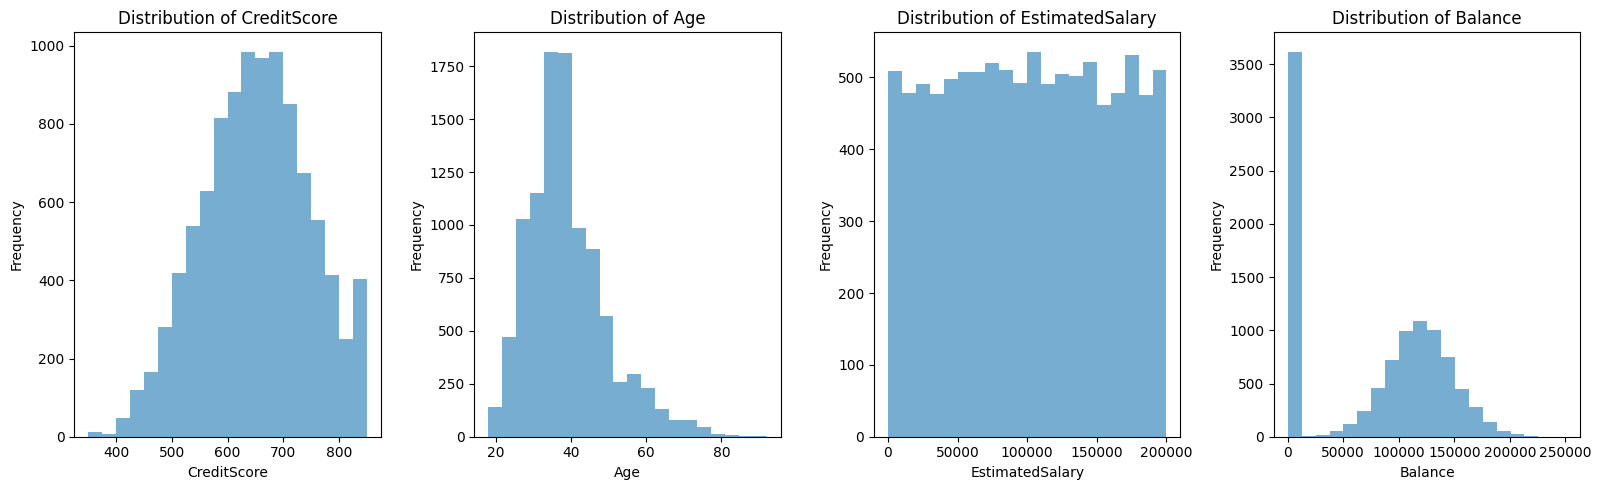

In [18]:
plots = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
plt.figure(figsize=(20, 5))

for i, column in enumerate(plots, 1):
    plt.subplot(1, 5, i)
    plt.hist(bank[column], bins=20, alpha=0.6)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Before building the machine learning models, it is important to evaluate the distributions of some variables to understand their characteristics and identify potential outliers. The CreditScore histogram shows a roughly normal distribution centered around 650, with most values falling between 500-800 and few extreme outliers. The Age distribution is right-skewed, peaking at 30-40 years and gradually declining towards older ages, indicating our customer base is predominantly younger. EstimatedSalary appears uniformly distributed across its range without noticeable skewness. The Balance distribution shows a spike at zero (approximately 3,500 customers) followed by a relatively even distribution throughout the higher balances. These observations suggest that while some features like Age deviate from normality, there are no extreme outliers that would need removal. The distributions appear reasonable for modeling, therefore, it is time to start testing out models.

## Creating the Model

In [19]:
print("Amount who exited:", bank[bank['Exited'] == 1]['Exited'].count())
print("Amount who stayed:", bank[bank['Exited'] == 0]['Exited'].count())

Amount who exited: 2037
Amount who stayed: 7963


In [20]:
bank = pd.get_dummies(bank, drop_first=True)
features = bank.drop(['Exited'], axis=1)
target = bank['Exited']

features_temp, features_train, target_temp, target_train = train_test_split(
    features, target, test_size=0.4, random_state=54321)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=54321)

print(f'Feature training size: {features_train.shape}')
print(f'Feature validation size: {features_valid.shape}')
print(f'Feature testing size: {features_test.shape}')
print(f'Target training size: {target_train.shape}')
print(f'Target validation size: {target_valid.shape}')
print(f'Target testing size: {target_test.shape}')

Feature training size: (4000, 11)
Feature validation size: (3000, 11)
Feature testing size: (3000, 11)
Target training size: (4000,)
Target validation size: (3000,)
Target testing size: (3000,)


In [21]:
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Logistic Regression (Imbalanced)")
print(f"F1 Score: {f1_score(target_valid, predicted_valid):2f}")
print(f"ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}")

Logistic Regression (Imbalanced)
F1 Score: 0.134431
ROC-AUC: 0.665317


As expected, the dataset has a significant class imbalance between customers who stayed with the bank and those who left. This imbalance can skew model performance, making it crucial to apply balancing techniques. After splitting the dataset into training, validation, and testing sets, I trained a logistic regression model without any hyperparameter tuning to establish a baseline. The results confirmed the need for improvement, resulting in an F1 score of 0.13—a clear indicator that the model struggles to predict churn accurately. Moving forward, I will first explore different tuning methods specifically for logistic regression, such as class balancing, upsampling the minority class, and downsampling the majority class. Once the best-performing tuning approach is identified, I will apply it to other models like decision trees and random forests to determine whether the improvements will also be applied to different methods.

In [22]:
model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Logistic Regression with Class Balance")
print(f"F1 Score: {f1_score(target_valid, predicted_valid):2f}")
print(f"ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}")

Logistic Regression with Class Balance
F1 Score: 0.442731
ROC-AUC: 0.716164


In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Logistic Regression with Upsampling')
print(f'F1 Score: {f1_score(target_valid, predicted_valid):2f}')
print(f'ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}')

Logistic Regression with Upsampling
F1 Score: 0.362058
ROC-AUC: 0.709494


In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)]+ [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)]+ [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('Logistic Regression with Downsampling')
print(f'F1 Score: {f1_score(target_valid, predicted_valid):2f}')
print(f'ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}')

Logistic Regression with Downsampling
F1 Score: 0.369689
ROC-AUC: 0.709494


After testing the three different approaches using logistic regression, the results show class balancing as the most effective strategy. This method achieved the highest F1 score of 0.443 and an ROC-AUC of 0.716, outperforming both upsampling (F1: 0.362, ROC-AUC: 0.709) and downsampling (F1: 0.370, ROC-AUC: 0.709). This performance of class balancing illustrates that adjusting class weights within the model itself gives better predictive power for identifying customer churn compared to resampling techniques. Now, I will adopt class balancing when evaluating other models, decision trees and random forests, to compare with the logistic regression results.

In [25]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, 
                                       random_state=54321, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions_valid)**0.5
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

model = RandomForestClassifier(random_state=54321, max_depth=best_depth, 
                               n_estimators=best_est, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Random Forest with Class Balance")
print(f"F1 Score: {f1_score(target_valid, predicted_valid):2f}")
print(f"ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}")

Random Forest with Class Balance
F1 Score: 0.602324
ROC-AUC: 0.847111


In [26]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=54321, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid)**0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

model = RandomForestClassifier(random_state=54321, max_depth=best_depth, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("Decision Tree with Class Balance")
print(f"F1 Score: {f1_score(target_valid, predicted_valid):2f}")
print(f"ROC-AUC: {roc_auc_score(target_valid, probabilities_one_valid):2f}")

Decision Tree with Class Balance
F1 Score: 0.590909
ROC-AUC: 0.843451


The comparative analysis of models using class balancing shows that the Random Forest algorithm has the strongest performance for Beta Bank's churn prediction task, achieving an F1 score of 0.602 and ROC-AUC of 0.847, superior to both Decision Trees and our earlier Logistic Regression implementations. With this best model identified, we will now proceed to the test dataset to verify real-world applicability.

## Testing the Best Model

In [27]:
model = RandomForestClassifier(random_state=54321, max_depth=10, n_estimators=20, class_weight='balanced')
model.fit(features_test, target_test)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_valid[:, 1]

print(f"F1 Score: {f1_score(target_test, predicted_test):2f}")
print(f"ROC-AUC: {roc_auc_score(target_test, probabilities_one_test):2f}")

F1 Score: 0.874898
ROC-AUC: 0.488745


To conclude this project, I evaluated the best-performing model on the test dataset to assess its real-world applicability. The model showed great predictive power, reaching an F1 score of 0.875 - a strong indicator of its ability to accurately identify customers at genuine risk of churning. However, the ROC-AUC score of 0.496 displays limitations in its capacity to effectively rank customers by their relative likelihood of churning. For Beta Bank's operational needs, this model is highly effective because of its strong classification performance will allow the company to focus its outreach efforts on customers most likely to churn. 